In [1]:
%matplotlib inline
import matplotlib
import seaborn as sns
sns.set()
matplotlib.rcParams['figure.dpi'] = 144

In [2]:
import expectexception

from pylib.draw_graph import draw_graph
from pylib.tensorboardcmd import tensorboard_cmd

<!-- requirement: pylib/__init__.py -->
<!-- requirement: pylib/draw_graph.py -->

# Introduction to TensorFlow


As artificial intelligence has advanced, applications have needed to process larger and larger amounts of data.  A prime example of this is the field of neural networks.  These machine learning models are enormously flexible and powerful, but they require huge amounts of both time and data to train.  Building tools to accomplish this can be difficult.

Google had been using neural networks internally for some time when they decided to develop a single framework flexible enough to be used for many different purposes.  That project became TensorFlow, and it was released as an open-source project in November, 2015.  Version 1.0 was released just over a year later, in February, 2017.

This generality has made TensorFlow useful for a number of different applications.  At its heart, it is a general-purpose computation engine, optimized for large data.  With TensorFlow, you define your program in terms of a computation graph.  Then, the graph is executed by letting data, in the form of tensors, flow through it.  (And you thought the name was just chosen to sound good!)

This course will introduce you to both the basics of TensorFlow and the basics of neural networks.  By focusing on the basics, we hope to convey a solid understanding of the theory and practice behind neural networks in TensorFlow.  For purposes of time, many of our example will be small and short, and therefore will not produce spectacular results.  Nonetheless, this should be enough to get you started on your own spectacular projects!


### Topics Covered


- Introduction to TensorFlow


- Iterative Algorithms


- Machine Learning


- Basic Neural Networks


- Deep Neural Networks
- Variational Autoencoders


- Convolutional Neural Networks


- Adversarial Noise
- DeepDream


- Recurrent Neural Networks


## Flow: The Computation Graph


In TensorFlow, computations are conceptualized as graphs.  These graphs are **directed** (the edges have a direction) and **acyclic** (there are no loops).  The nodes of the are **operations**, which may have zero or more inputs and zero or more outputs.  Hooking the output of one operation into the input of the next produces the computation graph.

Let's start with a simple demonstration.  Before we get going, we need to import TensorFlow.  The module name is `tensorflow`, but the usual convention is to import it as `tf`.  This avoids the namespace pollution that comes with an `import *`, but saves a lot of keystrokes over time.  We'll also import `numpy`, a Python library for numerical computation, as `np`, for future use.

In [3]:
import tensorflow as tf
import numpy as np

As a basic computation, let's implement this pure-Python calculation in TensorFlow:
```python
x = 2
y = 3
sum_ = x + y
```
It should come as no surprise that addition is an operation.  In fact, it's implemented in the `tf.add()` function.  If we were to draw a graph of just the addition function, it would look something like this:

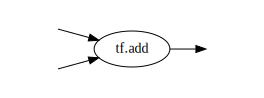

In [4]:
draw_graph("add-op")

The add operation takes two inputs and returns a single output.  Where do these inputs come from?  Other operations.  In this case, we'll use the `tf.constant()` operation.  This takes no input and produces a single output.

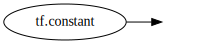

In [5]:
draw_graph("const-op")

We'll make a constant for each of `x` and `y` and connect these into the inputs of the add operation.  Constants can be made as follows.

In [6]:
x = tf.constant(2, name="input_x")
y = tf.constant(3, name="input_y")

The `tf.constant()` function takes a single required argument, the value of the constant in question.  The `name` keyword is optional.  It helps to identify operations when examining the graph, so naming key operations will certainly save you time later.

`x` and `y` are the output of operations, so they are tensors.

In [7]:
x

<tf.Tensor 'input_x:0' shape=() dtype=int32>

We'll discuss what exactly a tensor is later on.  For now, it's enough to remember that all values are tensors, so all input and output to operations should be tensors.

Now let's hook them up to calculate `x + y`.  The resulting graph should look like this.

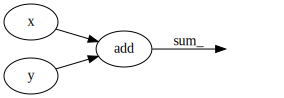

In [8]:
draw_graph("simple-graph")

In [9]:
sum_ = tf.add(x, y, name="sum")

The `tf.add()` operation also takes an optional name.  The result is another tensor.

In [10]:
sum_

<tf.Tensor 'sum:0' shape=() dtype=int32>

But what is the value of this tensor?  It doesn't have one, at least not yet.  TensorFlow takes a **lazy evaluation** model.  Values are not calculated until they are actually needed.  When we set `sum_` to be the output tensor of the add operation, that information was recorded into the computation graph, but nothing was calculated.  (The same thing also holds for `x` and `y`.)

To find the value of `sum_`, we need to TensorFlow that this value should be computed.  We do that with the `Session.run()` function.  (We'll discuss sessions shortly.)

In [11]:
sess = tf.Session()
sess.run(sum_)

5

When we ran the `sum_` tensor, TensorFlow could look at the computation graph and figure out that this was the output of the add operation.  Therefore, it needs to compute the inputs to this operation, namely the outputs of our two constant operations.  These tensors are fed into the add operation, and the output is fed back into Python for our use.  Graphically, something like this happened:

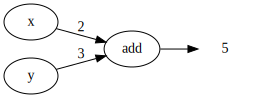

In [12]:
draw_graph("simple-graph-run")

Tensors override a number of Python's operators become TensorFlow operators.  We could have also have written

In [13]:
sum2 = x + y

Again, sum2 is a tensor, and its value is not calculated until we run the tensor.

In [14]:
sum2

<tf.Tensor 'add:0' shape=() dtype=int32>

In [15]:
sess.run(sum2)

5

The downside of this is that we could not give a name to this operation.  This doesn't affect the result of the computation, but it may make it harder to introspect the computation graph later.

The standard mathematical operations are overwritten.  Be careful about `==`.  While it has been overridden, it only actually just checks identity.  To check if two tensors have the same values, you must use the `tf.equals()` operation.

In [16]:
tf.constant(7) == tf.constant(7)

False

In [17]:
sess.run(tf.equal(tf.constant(7), tf.constant(7)))

True

## Exercise: Implementing a basic graph


Implement the following graph in TensorFlow.

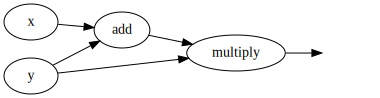

In [18]:
draw_graph("exercise")

Run the output and check that you get the right answer.

In [27]:
flow1=tf.multiply(x=sum_,y=y,name='multiply')

In [28]:
sess.run(flow1)

15

## Repeating calculations


All of this seems like a lot of work to just add a couple of numbers together.  And it is, really&mdash;if you're just doing a calculation once, setting it up in TensorFlow is probably overkill.  Most of the time, though, we'll want to repeat calculations multiple times.  Then the work of setting up the computation graph will pay off.

Part of this is the ability to compute only the necessary parts of a computation graph.  If you need to execute a partial result, you don't need to think about what leads into that computation.  TensorFlow will do exactly what needs to be computed and no more.

TensorFlow also allows you to repeat a calculation with a different input value.  You can change the values of constants by feeding new values in through the `feed_dict` argument of the `run()` method.  For example,

In [29]:
sess.run(flow1, feed_dict={x: 10, y: 20})

600

Note that the key in the `feed_dict` is the *tensor* itself, not its name.

Many times we will do set up computation graphs with the intention of feeding in values each time.  To make sure we don't forget any keys in the `feed_dict`, we can use **placeholders**.  A placeholder is an operation much like a constant, but it needs to have a value fed in each time the graph is run.

In [31]:
xp = tf.placeholder(dtype=tf.int32)
sum_p = tf.add(xp, y)
sess.run(sum_p, {xp: 5, y:10})

15

If we don't specify the feed values, we get an error.  (Note that the error occurs during the execution, and therefore comes from another process.  The result is that the traceback gets very hard to read.)

In [32]:
%%expect_exception tf.errors.InvalidArgumentError

sess.run(sum_p)

---------------------------------------------------------------------------
InvalidArgumentError                      Traceback (most recent call last)
/opt/conda/envs/data3/lib/python3.6/site-packages/tensorflow/python/client/session.py in _do_call(self, fn, *args)
   1277     try:
-> 1278       return fn(*args)
   1279     except errors.OpError as e:

/opt/conda/envs/data3/lib/python3.6/site-packages/tensorflow/python/client/session.py in _run_fn(feed_dict, fetch_list, target_list, options, run_metadata)
   1262       return self._call_tf_sessionrun(
-> 1263           options, feed_dict, fetch_list, target_list, run_metadata)
   1264 

/opt/conda/envs/data3/lib/python3.6/site-packages/tensorflow/python/client/session.py in _call_tf_sessionrun(self, options, feed_dict, fetch_list, target_list, run_metadata)
   1349         self._session, options, feed_dict, fetch_list, target_list,
-> 1350         run_metadata)
   1351 

InvalidArgumentError: You must feed a value for placeholder tens

You may have noticed that we had to specify the `dtype` of our placeholder tensor.  That means that it's time to discuss what exactly we mean by "tensor".


## Tensor: The data types and shapes


For our purposes, a tensor can be thought of as a generalization of a matrix.  A vector is a one-dimensional array of numbers and a matrix is a two-dimensional array.  A tensor then is an *n*-dimensional array of numbers.  Both vectors and matrices are just special cases of tensors.  (Mathematicians may quibble with this definition, insisting that tensors are defined by how they transform under coordinate transformations.  They have a point, but one that doesn't matter for the purposes of TensorFlow.)

Thus, when specifying a tensor, we must give both the number of dimensions and the size of each dimension.  This is done through the `shape` data, which contains the size of each dimension.  If we look at an existing tensor, we can see that it has a shape of `[]`, indicating a scalar.

In [33]:
x.shape

TensorShape([])

If we make a $2\times3$ matrix, for example, we see that this is reflected in its shape.

In [34]:
tf.constant([[1,2,3],[4,5,6]]).shape

TensorShape([Dimension(2), Dimension(3)])

In this case, TensorFlow is able to work out the shape from the input values.  With placeholders, however, we generally will need to specify it.  We can give the dimensions in a tuple.

In [35]:
mat = tf.placeholder(dtype=tf.int32, shape=(2, 3))

Now we have to give an appropriately shaped value in the `feed_dict`.  Note that this check happens at "compile" time, before any computation actually takes place.

In [36]:
%%expect_exception ValueError

sess.run(mat, {mat: [[1,2],[3,4]]})

---------------------------------------------------------------------------
ValueError                                Traceback (most recent call last)
<ipython-input-36-d8ff53edaffe> in <module>()
      1 
----> 2 sess.run(mat, {mat: [[1,2],[3,4]]})

/opt/conda/envs/data3/lib/python3.6/site-packages/tensorflow/python/client/session.py in run(self, fetches, feed_dict, options, run_metadata)
    875     try:
    876       result = self._run(None, fetches, feed_dict, options_ptr,
--> 877                          run_metadata_ptr)
    878       if run_metadata:
    879         proto_data = tf_session.TF_GetBuffer(run_metadata_ptr)

/opt/conda/envs/data3/lib/python3.6/site-packages/tensorflow/python/client/session.py in _run(self, handle, fetches, feed_dict, options, run_metadata)
   1074                              'which has shape %r' %
   1075                              (np_val.shape, subfeed_t.name,
-> 1076                               str(subfeed_t.get_shape())))
   1077          

But if we give it the right-sized input, everything works just fine.

In [37]:
sess.run(mat, {mat: [[1,2,3],[4,5,6]]})

array([[1, 2, 3],
       [4, 5, 6]], dtype=int32)

We can use a dimension of `None` to indicate that a tensor can have arbitrary size along that dimension.  (Dimension mismatches here can only be caught at execution time.)

In [38]:
mat2 = tf.placeholder(dtype=np.int32, shape=(2, None))
print(sess.run(mat2, {mat2: [[1],[2]]}))
sess.run(mat2, {mat2: [[1,2,3],[4,5,6]]})

[[1]
 [2]]


array([[1, 2, 3],
       [4, 5, 6]], dtype=int32)

The `array` object returned is provided by [NumPy](http://www.numpy.org/).

In [39]:
type(sess.run(mat2, {mat2: [[1,2,3],[4,5,6]]}))

numpy.ndarray

TensorFlow uses NumPy arrays to represent all (non-scalar) values.  NumPy arrays are used widely in the scientific Python community for numeric computations, as they represent a significant improvement over Python lists for these purposes.

Python lists are **heterogeneous** and can be **resized**.  This makes them useful for interactive programming, as any value can be added to any list.  However, it slows computation, since we have to do a pointer lookup to access each value (and additional look-ups to find the relevant functions).

In contrast, NumPy arrays are **homogeneous** and **fixed-size**.  This means that their contents can be stored contiguously in memory.  Operations can easily be broadcast to act over each element in the array.  Arrays can be of arbitrary dimensions, so they are a good fit for tensors.  NumPy arrays can be constructed out of nested lists, which we were taking advantage of previously.

Because they are homogeneous, arrays (and therefore tensors) must specify which type of data they can contain.  This is indicated by an array's `dtype`.  The issue of type goes beyond simply `float` versus `int`&mdash;there are a variety of levels of precision.  As we can see above, the default integer type is 32 bits.  These types exist in both the `numpy` and `tensorflow` namespaces, where there are generally equivalent.

In [40]:
np.int32 == tf.int32

True

We can specify which `dtype` to use when creating operators.

In [41]:
x_int64 = tf.constant(2, dtype=np.int64)
x_float16 = tf.constant(2, dtype=np.float16)
sess.run([x_int64, x_float16])

[2, 2.0]

While we can often get away with type inference, this sometimes leads to type mismatches in graphs.  It's generally good practice to specify the type, just to be safe.

Here are the `dtype`s provided by NumPy.

In [42]:
np.sctypes

{'int': [numpy.int8, numpy.int16, numpy.int32, numpy.int64],
 'uint': [numpy.uint8, numpy.uint16, numpy.uint32, numpy.uint64],
 'float': [numpy.float16, numpy.float32, numpy.float64, numpy.float128],
 'complex': [numpy.complex64, numpy.complex128, numpy.complex256],
 'others': [bool, object, bytes, str, numpy.void]}

Most basic TensorFlow operations act element-wise.  This means that the shape of the output tensor is the same as that of the input tensors.

In [43]:
mat.shape, (mat + mat).shape

(TensorShape([Dimension(2), Dimension(3)]),
 TensorShape([Dimension(2), Dimension(3)]))

Be aware the multiplication is also element-wise by default.

In [44]:
sess.run(mat2 * mat2, {mat2: [[1,2],[3,4]]})

array([[ 1,  4],
       [ 9, 16]], dtype=int32)

To actually do matrix multiplication, you can use the `tf.matmul` operation.

In [45]:
sess.run(tf.matmul(mat2, mat2), {mat2: [[1,2],[3,4]]})

array([[ 7, 10],
       [15, 22]], dtype=int32)

Alternatively, Python 3's `@` operator also does matrix multiplication.

In [46]:
sess.run(mat2 @ mat2,  {mat2: [[1,2],[3,4]]})

array([[ 7, 10],
       [15, 22]], dtype=int32)

Obviously, matrix multiplication may result in a differently-shaped output.

TensorFlow provides a number of `reduce_*` operations.  These run the specified reduction function over the specified axis, or over all axes if none is specified.  This will sum the columns of the matrix, for example.

In [47]:
sess.run(tf.reduce_sum(mat, axis=0), {mat: [[1,2,3],[4,5,6]]})

array([5, 7, 9], dtype=int32)

## Exercise: Reducing tensors of arbitrary shape


Write a graph to take in a $5\times n$ tensor of floats and return a single float, the sum of the squares of the average value of each row.  Test it on the following inputs.

In [48]:
matph = tf.placeholder(dtype=np.float, shape=(5, None))

In [49]:
np.random.seed(1)
input1 = np.random.randn(5, 2)
# Answer: 1.6559478

In [51]:
input1

array([[ 1.62434536, -0.61175641],
       [-0.52817175, -1.07296862],
       [ 0.86540763, -2.3015387 ],
       [ 1.74481176, -0.7612069 ],
       [ 0.3190391 , -0.24937038]])

In [61]:
means = tf.reduce_mean(matph, axis=1)
sqr = tf.square(means)
sumsqr = tf.reduce_sum(sqr, axis=1)
sess.run(sumsqr)

ValueError: Invalid reduction dimension 1 for input with 1 dimensions. for 'Sum_5' (op: 'Sum') with input shapes: [5], [] and with computed input tensors: input[1] = <1>.

In [ ]:
np.random.seed(2)
input2 = np.random.randn(5, 200)
# Answer: 0.035791952

## Graphs


Thus far, we have been referring to the computation graph as some abstract concept.  It's actually a real thing.  TensorFlow provides a default graph, to which operations are added by default.  We can get a reference to it, if we'd like.

In [62]:
g = tf.get_default_graph()

print(g)

We can get a list of all the operations on the current graph:

In [63]:
g.get_operations()

[<tf.Operation 'input_x' type=Const>,
 <tf.Operation 'input_y' type=Const>,
 <tf.Operation 'sum' type=Add>,
 <tf.Operation 'add' type=Add>,
 <tf.Operation 'Const' type=Const>,
 <tf.Operation 'Const_1' type=Const>,
 <tf.Operation 'Const_2' type=Const>,
 <tf.Operation 'Const_3' type=Const>,
 <tf.Operation 'Equal' type=Equal>,
 <tf.Operation 'multiply' type=Mul>,
 <tf.Operation 'multiply_1' type=Mul>,
 <tf.Operation 'multiply_2' type=Mul>,
 <tf.Operation 'Placeholder' type=Placeholder>,
 <tf.Operation 'Add_1' type=Add>,
 <tf.Operation 'Placeholder_1' type=Placeholder>,
 <tf.Operation 'Add_2' type=Add>,
 <tf.Operation 'Const_4' type=Const>,
 <tf.Operation 'Placeholder_2' type=Placeholder>,
 <tf.Operation 'Placeholder_3' type=Placeholder>,
 <tf.Operation 'Const_5' type=Const>,
 <tf.Operation 'Const_6' type=Const>,
 <tf.Operation 'add_3' type=Add>,
 <tf.Operation 'mul' type=Mul>,
 <tf.Operation 'MatMul' type=MatMul>,
 <tf.Operation 'matmul_1' type=MatMul>,
 <tf.Operation 'Sum_1/reduction_ind

Those are all of the operations that we've created in this notebook.  We've been using the default graph for convenience, but it's better practice to use a dedicated graph for each computation.  (That said, remember that TensorFlow is smart enough to only evaluate the necessary operations to give us any particular result.)  We can instantiate a new graph like so:

In [64]:
g2 = tf.Graph()

The easiest way to add operations to a particular graph is to use the `as_default()` context handler.

In [65]:
with g2.as_default():
    a = tf.constant(12, name="constant_a")
    b = tf.constant(16, name="constant_b")
    sum_g2 = a + b

We can see these operations got added to the new graph.

In [66]:
g2.get_operations()

[<tf.Operation 'constant_a' type=Const>,
 <tf.Operation 'constant_b' type=Const>,
 <tf.Operation 'add' type=Add>]

As an issue of best practices, you should not do as we've done here, using the default graph implicitly for some operations and a second graph explicitly for other.  If you need multiple graphs, it's best to assemble each in its own `with` block, so that there's no confusion about which graph is getting which operations.


## Sessions


We've already created a session to run operations previously.  The session abstracts the environment in which a graph is executed.  Each session is associated with a specific graph, so if we want to evaluate `sum_g2`, we'll have to make a session for it.

In [67]:
sess2 = tf.Session(graph=g2)

Now, we can run it.

In [68]:
sess2.run(sum_g2)

28

Multiple sessions can reference the same graph.  Each of them keeps track of its internal state separately, as we'll see when discussing variables in the next notebook.  If you don't specify a graph when creating a session, the default graph is used.

In [69]:
tf.Session().graph == g

True

When you are finished with a session, remember to close it, to free the associated resources.

In [70]:
sess2.close()

Alternatively, you can use sessions as context managers.  They close themselves on exit, so you don't have to do this explicitly.

In [71]:
with tf.Session(graph=g2) as s2:
    print(s2.run(sum_g2))

28


This is probably the best approach if you find yourself using multiple sessions.  However, in these notebooks, we tend to have sessions that need to span multiple cells.  We have a little reset function that we'll be using instead.  It closes the current session and opens a new one, in the global variable `sess`.  It also resets the default graph.  All of our work will be in these objects.

In [72]:
def reset_tf():
    global sess
    if sess:
        sess.close()
    tf.reset_default_graph()
    sess = tf.Session()

> **Aside:** TensorFlow also provides an `InteractiveSession` designed for use in interactive environments like this one.  It allows you to use the `eval()` method on tensors to get their values in the default session.  We think "Explicit is better than implicit," at least for learning, so we're using sessions explicitly.  But once you get a handle on these concepts, you might find that `InteractiveSession` speeds up your work.


## TensorBoard


[TensorBoard](https://www.tensorflow.org/get_started/summaries_and_tensorboard) is a web-based tool to help you visualize your TensorFlow graphs and runs.  While running your graphs, you write to event files.  When you launch TensorBoard, it will run a local web server with visualizations of this material.  A `FileWriter` is used to create these files.

In [73]:
writer = tf.summary.FileWriter('./tb/intro_graph', g)

tensorboard_cmd('tb/intro_graph')

<IPython.core.display.Javascript object>

Now you can launch `tensorboard`.  As the instructions above say, on a terminal in this directory, run
```bash
tensorboard --logdir=tb/intro_graph
```
This will start up a web server on port 6006.  If you are running this on your own computer, you can just visit `localhost:6006`.  On the training cloud computer, you can't access this port directly.  Instead, we've set up a proxy to forward these connections.  Use the link in the output above.

Visiting TensorBoard, you will see nothing on the first page.  If you click on the "Graphs" header, though, you'll get a visualization of the computation graph.  This allows you to zoom and scroll through the graph, examining the operations and the tensors passed between them.  Right now, you'll probably see a lot of small, disconnected sub-graphs.  That's what's constructed in this notebook, but this is an atypical use.

Another useful capability of TensorBoard is to keep track of some value each time a computation is run.  (This will be useful to track the evolving loss as a model is being trained, for example.)  For example, to track `sum_` each time we run it, we can create a summary operation.

In [74]:
tf.summary.scalar('sum_', sum_)

<tf.Tensor 'sum_:0' shape=() dtype=string>

We also need to merge all of the summaries together.  It's sort of pointless here, with a single summary, but this would allow us to generate multiple summaries in a single operation.

In [75]:
merged = tf.summary.merge_all()

Now, we can run both the summation of the summary generation step and use the `writer.add_summary` method to write the summary to the event file.  This function takes an optional second argument, a step counter.  This allows you to track how a summary value changes over time.

In [76]:
for i in range(10):
    summary, _ = sess.run([merged, sum_], {x: 10*i, y: -i*i})
    writer.add_summary(summary, i)

It's good practice to close the `FileWriter` when you're done with it.

In [77]:
writer.close()

You'll need to stop and restart the `tensorboard` server.  Once you do, you should see *sum_* on the "Scalars" page, plotting how it changes over time.

Be careful about re-running this code.  It will write another event file to the same directory, which can slightly confuse `tensorboard`.  One solution is to include the current time in the directory name passed to the `FileWriter`.

We don't make too much use of TensorBoard in these notebooks, preferring visualizations that we've integrated into the notebook.  Don't let that dissuade you from using it in your own work!

*Copyright &copy; 2017 The Data Incubator.  All rights reserved.*